# spacetrackのテスト その3

長期間の軌道データを調べてみる

In [1]:
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
from datetime import datetime
import numpy as np
import pandas as pd
import time
import json
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# userid and password are set in here
import spacetrackaccount
# print("Login with " + spacetrackaccount.userid)

In [4]:
st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)

In [5]:
def mycallback(until):
    duration = int(round(until - time.monotonic()))
    print('Sleeping for {:d} seconds.'.format(duration))

st.callback = mycallback

In [6]:
# Hinodeの軌道データをJSON形式でダウンロード (既にダウンロード済みの場合はそれを使う)
file = 'download/tle_29479_all.json'
if not os.path.isfile(file):
    print('Downloading new data')
    data = st.tle(norad_cat_id=29479, orderby='epoch', format='json')
    with open(file, 'w') as fp:
        fp.write(data)
    df = pd.read_json(data)
else:
    print('Using pre-existing data')
    df = pd.read_json(file)

Using pre-existing data


In [7]:
# Timestamp型(datetime64[ns])に変換する
df['EPOCH2'] = pd.to_datetime(df['EPOCH'] + '.' + df['EPOCH_MICROSECONDS'].map('{:06}'.format))

In [8]:
# EPOCH2でソートする
df = df.sort_values(['EPOCH2', 'FILE']).reset_index(drop=True)

In [9]:
# EPOCH2が同じデータが複数存在する場合、最後のデータのみを残す
print(len(df))
df = df[~df.duplicated(subset='EPOCH2', keep='last')]
print(len(df))

8446
8396


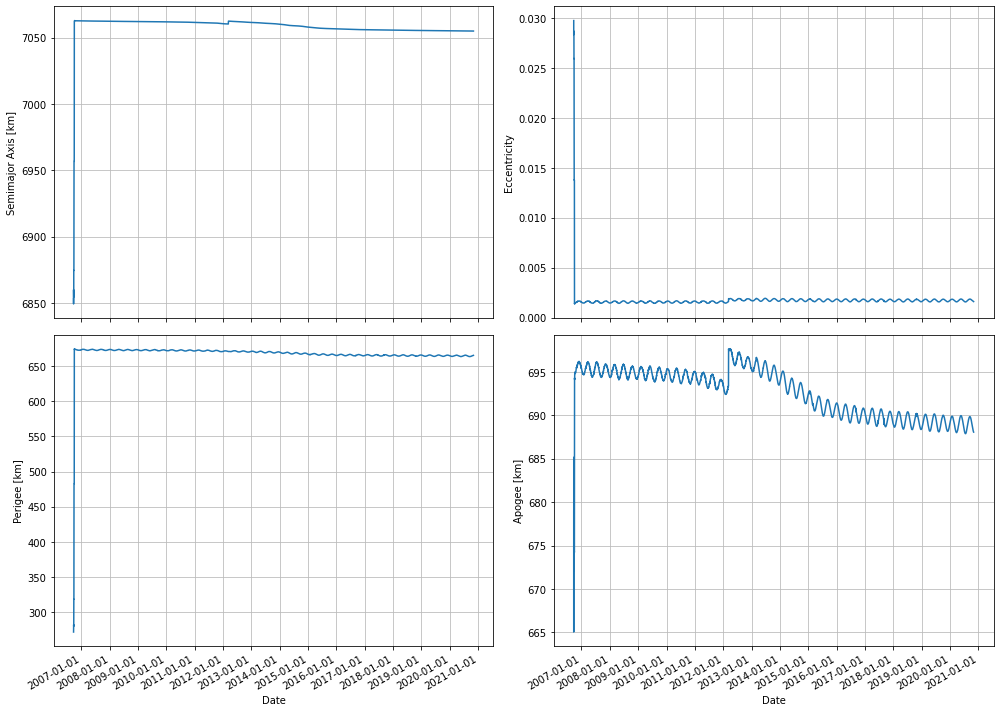

In [10]:
# 軌道長半径、離心率、近地点、遠地点の時間変化をプロット
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(df['EPOCH2'], df['SEMIMAJOR_AXIS'])
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(df['EPOCH2'], df['ECCENTRICITY'])
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Eccentricity")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(df['EPOCH2'], df['PERIGEE'])
ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Perigee [km]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(df['EPOCH2'], df['APOGEE'])
ax4.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax4.set_xlabel("Date")
ax4.set_ylabel("Apogee [km]")
ax4.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [11]:
# 軌道長半径の時間変化
oneday = pd.Timedelta(days=1)
DT = df['EPOCH2'].diff() / oneday
DSEMIMAJOR_AXIS = df['SEMIMAJOR_AXIS'].diff() / DT

In [12]:
DSEMIMAJOR_AXIS.describe()

count      8395.000000
mean        -26.912733
std        7464.371634
min     -534796.064714
25%          -0.002437
50%          -0.001044
75%           0.000000
max      299999.999970
dtype: float64

In [13]:
(DT * 86400).describe()

count      8395.000000
mean      53034.621947
std       32766.098024
min           0.000863
25%       29507.140080
50%       47280.031777
75%       76834.246033
max      402766.039872
Name: EPOCH2, dtype: float64

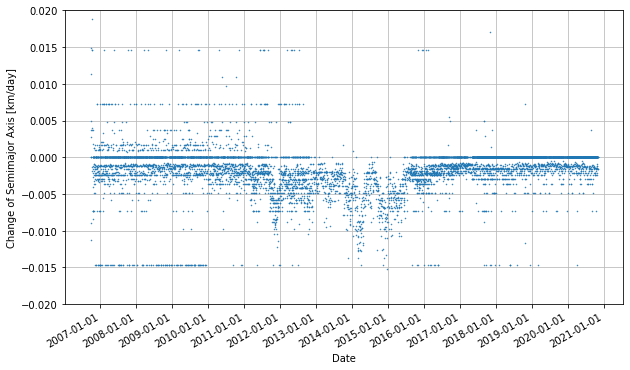

In [14]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH2'], DSEMIMAJOR_AXIS, ".", markersize=1)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

ノイズが多くてよくわからないのでデータを間引く

In [15]:
# 1日平均と週平均 (EPOCH2がインデックスになる)
df2 = df.resample('D', on='EPOCH2').mean()
df3 = df.resample('W', on='EPOCH2').mean()
print(len(df), len(df2), len(df3))

8396 5155 737


In [16]:
# 軌道長半径の時間変化
DSEMIMAJOR_AXIS2 = df2['SEMIMAJOR_AXIS'].diff()
DSEMIMAJOR_AXIS3 = df3['SEMIMAJOR_AXIS'].diff() / 7.0

In [17]:
DSEMIMAJOR_AXIS2.describe()

count    4730.000000
mean        0.042917
std         1.786391
min        -0.709556
25%        -0.002000
50%        -0.001000
75%        -0.000500
max       105.555000
Name: SEMIMAJOR_AXIS, dtype: float64

In [18]:
DSEMIMAJOR_AXIS3.describe()

count    736.000000
mean       0.038860
std        0.819210
min       -0.011524
25%       -0.002564
50%       -0.000958
75%       -0.000670
max       20.015167
Name: SEMIMAJOR_AXIS, dtype: float64

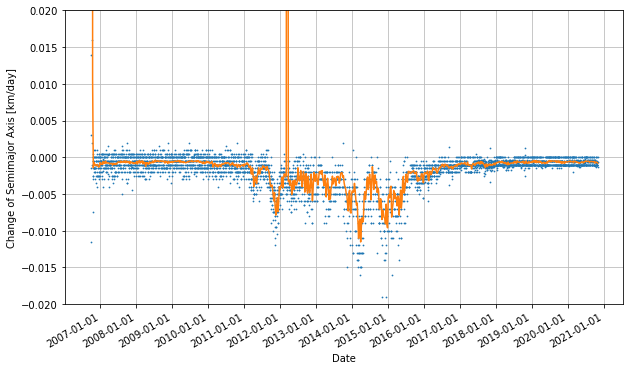

In [19]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df2.index, DSEMIMAJOR_AXIS2, '.', markersize=1.5)
ax1.plot(df3.index, DSEMIMAJOR_AXIS3)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

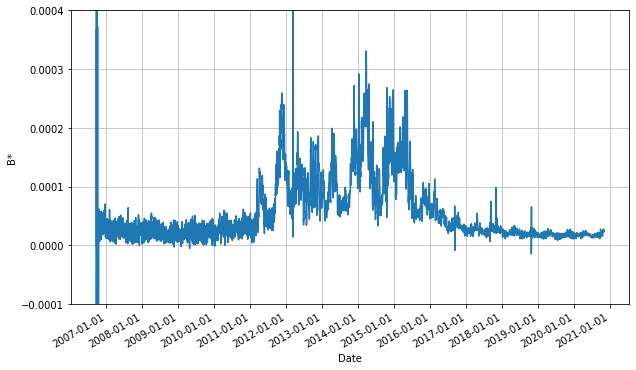

In [20]:
# 抗力項 BSTAR をプロット
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH2'], df['BSTAR'])
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("B*")
ax1.set_ylim(-0.0001, 0.0004)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()